# Assignment-2 : Part-2

### Import Dependencies and Unzip "CelebAMask-HQ" dataset.

In [1]:
# Mounting Google drive for loading the checkpoint.

from google.colab import drive
drive.mount('/content/gdrive')

!cd gdrive/MyDrive/

# Unizp the "CelebAMask-HQ.zip" file located in same directory as main file
!unzip -q gdrive/MyDrive/Fall_21/P3_temp/CelebAMask-HQ.zip && ls CelebAMask-HQ

import os
import random
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib import pyplot as PLT

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor, Lambda
import torchvision.models as models
from torch.hub import load_state_dict_from_url
from torchvision.models.segmentation.deeplabv3 import DeepLabHead
#from torchvision import models


torch.cuda.empty_cache()
cuda = torch.device('cuda') 
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Mounted at /content/gdrive
CelebA-HQ-img			  CelebAMask-HQ-mask-anno
CelebA-HQ-to-CelebA-mapping.txt   CelebAMask-HQ-pose-anno.txt
CelebAMask-HQ-attribute-anno.txt  README.txt
Using cuda device


### Preprocessing: Collate all image's path address & labels as a input to custom pytorch dataset

In [2]:
label_list = ['skin', 'nose', 'eye', 'l_eye', 'r_eye', 'l_brow', 'r_brow', 'l_ear', 'r_ear', 'mouth', 'u_lip', 'l_lip', 'hair', 'hat', 'ear_r', 'neck_l', 'neck', 'cloth']
labels_dict = {'background': 0, 'skin': 1, 'nose': 2, 'eye': 3, 'l_eye': 4, 'r_eye': 5, 'l_brow': 6,	'r_brow': 7, 'l_ear': 8, 'r_ear': 9, 'mouth': 10, 'u_lip': 11, 'l_lip': 12, 'hair': 13, 'hat': 14, 'ear_r': 15, 'neck_l': 16, 'neck': 17, 'cloth': 18 }	
rgb = [[0,0,0],[255,192,203],[255,0,0],[0,255,0],[0,0,255],[255,255,0],[0,255,255],[255,0,255],[192,192,192],[138,43,226],[245,245,220],[0,250,154],[255,127,80],[0,0,128],[100,149,237],[216,191,216],[210,105,30],[169,169,169],[188,143,143]]


file_list = []


for file in os.listdir('./CelebAMask-HQ/CelebA-HQ-img/'):
    
    if file == '.DS_Store':
        continue
    
    idx = file 
    idx = os.path.splitext(idx)[0]
 

    idx_5dig = idx.rjust(5, '0')
   


    temp_list = []

    temp_list.append('./CelebAMask-HQ/CelebA-HQ-img/'+file)
    
    
    
    part_f = int(idx) // 2000
    part_f = str(part_f)
   
    for i,j in enumerate(label_list):
        

        filename = os.path.join('./CelebAMask-HQ/CelebAMask-HQ-mask-anno/'+ part_f +'/'+ idx_5dig + '_' + j + '.png')
       
        if (os.path.exists(filename)):
            temp_list.append(filename)
        else:
            temp_list.append(None)

   
        file_list.append(temp_list)
        
# Partitioning into training & testing files
part_ratio = int(2/3*len(file_list))
random.shuffle(file_list)
file_list_train = file_list[:part_ratio]
file_list_test = file_list[part_ratio:]

### Utility function for Dataloaders. It handles label files & encodes them into appropriate type & dimensions. It converts all "White Pixels with value of 255" to "class index + 1" & floors all other pixels to 0.

In [3]:
def label_func(fn,w,h):

  #lab = np.zeros((512,512))
  lab = np.zeros((224,224))
 

  for ind,_path in enumerate(fn):
    

    if _path != None:
      image = Image.open(_path)
      image =  image.convert('L')
      #image = image.resize((512,512))
      image = image.resize((224,224))
      pix = np.array(image)

      pix[ pix != 255] = 0
      pix[ pix == 255] = ind+1
      
      
      lab = np.maximum(lab,pix)
  

    else:
      #pix = np.zeros((512,512))
      #pix = np.reshape(pix,(1,512,512))
      pix = np.zeros((224,224))
      lab = np.maximum(lab,pix)

   
  return lab

### Custom Pytorch datatset for training images of "CelebAMask-HQ" dataset.

In [4]:
class TrainCelebDataset(Dataset):
    def __init__(self, f_list, transform=None):

        self.filenames = f_list
        self.transform = transform
    

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):

        img_path = self.filenames[idx][0]
        image = None
       
        with open(img_path, 'rb') as f:
          image = Image.open(f)
          image =  image.convert('RGB')

          iw,ih = image.size
          
          
        
       
        
        label = label_func(self.filenames[idx][1:],iw,ih)
       
      
        label = np.array(label, dtype=np.byte)
       

        if self.transform is not None:

            image = self.transform(image)
            #label = self.transform(label)
            
        return image, label


class TrainSet(TrainCelebDataset):
  
    def __init__(self, f_list, transform=None):

        super(TrainSet, self).__init__(f_list, transform=transform)

### Custom Pytorch datatset for testing images of "CelebAMask-HQ" dataset.

In [5]:
class TestCelebDataset(Dataset):
    def __init__(self, f_list, transform=None):

        self.filenames = f_list
        self.transform = transform
    

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):

        img_path = self.filenames[idx][0]
        image = None
       
        with open(img_path, 'rb') as f:
          image = Image.open(f)
          image =  image.convert('RGB')
          
        
       

        label = label_func(self.filenames[idx][1:])
        label = np.array(label, dtype=np.byte)
       

        if self.transform is not None:

            image = self.transform(image)
            #label = self.transform(label)
            
        return image, label


class TestSet(TrainCelebDataset):
  
    def __init__(self, f_list, transform=None):

        super(TestSet, self).__init__(f_list, transform=transform)

### Instantiating Dataset loaders for training & testing

In [6]:
trans = transforms.Compose([
            #transforms.Resize((512, 512)),
            transforms.Resize((224, 224)),
            transforms.ToTensor()
        ])

trainset = TrainSet(f_list=file_list_train, transform=trans)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=50, shuffle=True, num_workers=4)



trans = transforms.Compose([
            #transforms.Resize((512, 512)),
            transforms.Resize((224, 224)),
            transforms.ToTensor()
        ])

testset = TestSet(f_list=file_list_test, transform=trans)
testloader = torch.utils.data.DataLoader(testset, batch_size=20, shuffle=True, num_workers=4)

In [7]:
len(trainloader)

7200

### Define & Instantiate a customize open-sourced "DeepLab" implementation for our specific use case with 19 classes. Also define optimizers & criterion (i.e. loss function)

In [8]:
def create_model(outputchannels=19):
    model = models.segmentation.deeplabv3_mobilenet_v3_large(pretrained=True, progress=True)
    model.classifier = DeepLabHead(960, outputchannels)
    model.train()
    return model

model = create_model()
model = model.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

Downloading: "https://download.pytorch.org/models/deeplabv3_mobilenet_v3_large-fc3c493d.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_mobilenet_v3_large-fc3c493d.pth


  0%|          | 0.00/42.3M [00:00<?, ?B/s]

### Training Function

In [9]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
      
        X, y = X.to(device), y.long().to(device)
        optimizer.zero_grad()
        torch.set_grad_enabled(True)
    
        
        pred = model(X)

        pred = pred['out']
       

        loss = loss_fn(pred, y)

       
        loss.backward()
        optimizer.step()

    
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    return loss

### Defining "Learning Rate Scheduler" & "Early stopping mechanism"

In [11]:
class LRScheduler():
  
    def __init__(
        self, optimizer, patience=5, min_lr=1e-7, factor=0.75
    ):
        
        self.optimizer = optimizer
        self.patience = patience
        self.min_lr = min_lr
        self.factor = factor
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau( 
                self.optimizer,
                mode='min',
                patience=self.patience,
                factor=self.factor,
                min_lr=self.min_lr,
                verbose=True
            )
    def __call__(self, val_loss):
        self.scheduler.step(val_loss)


class EarlyStopping():
   
    def __init__(self, patience=5, min_delta=0):
      
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
    def __call__(self, val_loss):
        if self.best_loss == None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

### Instantiating, training & checkpoint for our model

#### There are 2 cells for "model" that are given below.
#### Run the 1st cell in case you want to load a checkpoint & resume training.
#### Else Run the 2nd cell in case you want to start training from scratch.

#### **NOTE: Make sure to change the path of loading the checkpoint in 1st cell**

In [12]:
# **NOTE: Make sure to change the path of loading the checkpoint in 1st cell**
checkpoint = torch.load('gdrive/MyDrive/Fall_21/P3_temp/trained-model.ckpt')


model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch'] + 1
loss = checkpoint['loss']


In [13]:
# **NOTE: Make sure to change the path of loading the checkpoint in 1st cell**
#checkpoint = torch.load('gdrive/MyDrive/Fall_21/P3_temp/trained-model.ckpt')


#model.load_state_dict(checkpoint['model_state_dict'])
#optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#epoch = checkpoint['epoch'] + 1
#loss = checkpoint['loss']



#es =  EarlyStopping()
lrs = LRScheduler(optimizer)

checkpoint_dir = "."
test_loss = 0
train_loss = 0
epochs = 5

for i in range(epochs):
    print(f"Epoch {i+1}")
    train_loss = train(trainloader, model, criterion, optimizer)
    

    torch.save({
        'epoch': i+1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': test_loss
        }, checkpoint_dir+'/%04d-model.ckpt' %i)
    
  
    lrs(train_loss)
    #es(test_loss)
    #if es.early_stop:
    #  break

Epoch 1
loss: 0.131141  [    0/360000]
loss: 0.132973  [ 5000/360000]
loss: 0.131748  [10000/360000]
loss: 0.136481  [15000/360000]
loss: 0.136670  [20000/360000]
loss: 0.135466  [25000/360000]
loss: 0.138918  [30000/360000]
loss: 0.135848  [35000/360000]
loss: 0.133911  [40000/360000]
loss: 0.136194  [45000/360000]
loss: 0.132704  [50000/360000]
loss: 0.131486  [55000/360000]
loss: 0.136079  [60000/360000]
loss: 0.133717  [65000/360000]
loss: 0.137901  [70000/360000]
loss: 0.126883  [75000/360000]
loss: 0.131456  [80000/360000]
loss: 0.136046  [85000/360000]
loss: 0.129650  [90000/360000]
loss: 0.137403  [95000/360000]
loss: 0.135842  [100000/360000]
loss: 0.134371  [105000/360000]
loss: 0.126063  [110000/360000]
loss: 0.129486  [115000/360000]
loss: 0.135373  [120000/360000]
loss: 0.134539  [125000/360000]
loss: 0.127152  [130000/360000]
loss: 0.128661  [135000/360000]
loss: 0.134301  [140000/360000]
loss: 0.125558  [145000/360000]
loss: 0.129183  [150000/360000]
loss: 0.134939  [155

KeyboardInterrupt: ignored

#### Run the 2nd cell in case you want to start training from scratch.

In [ ]:
#es =  EarlyStopping()
#lrs = LRScheduler(optimizer)

checkpoint_dir = "."
test_loss = 0
train_loss = 0
epochs = 5

for i in range(epochs):
    print(f"Epoch {i+1}")
    train_loss = train(trainloader, model, criterion, optimizer)

    torch.save({
        'epoch': i+1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': test_loss
        }, checkpoint_dir+'/%04d-model.ckpt' %i)
    
    lrs(train_loss)
    #es(test_loss)
    #if es.early_stop:
    #  break

Epoch 1


NameError: ignored

### Utility function to expand target/labels "y" into "n" channels, where n = number of classes (i.e. 19 in our case) 

In [14]:
def unravel(y):

  by = None

  for bi, bt in enumerate(y):
    fg = 0
    ry = None
    for i in range(19):
      yi = torch.where(bt == i,1,0)
      yi = yi.reshape((1,yi.shape[0],yi.shape[1]))
      if fg == 0:
        ry = yi
        fg = 1
      else:
        ry = torch.vstack((ry,yi)) 

    if bi == 0:
      by = ry.reshape((1,ry.shape[0],ry.shape[1],ry.shape[2]))
    else:
      ry = ry.reshape((1,ry.shape[0],ry.shape[1],ry.shape[2]))
      by = torch.vstack((by,ry))

  return by

#yrv = unravel(y).to(device)

### Utility function to convert calculate "Softmax values" for the predicted output values from our model.

In [15]:
def out_sf(out):
  #ceil = nn.functional.softmax(out.reshape(out.size(0), out[0].size(1), -1), 2).view_as(out)
  sf = nn.functional.softmax(out, 1)
  return sf

#outc = out_sf(out).to(device)

### Utility function to ceil/floor predictions[Softmax] "y" to either 0 or 1 based on some "confidence Threshold".

In [16]:
def unravel_out(y):

  by = None

  for bi, bt in enumerate(y):
    fg = 0
    ry = None
    for i in range(19):
      yi = torch.where(bt[i] > 0.2,1,0)
      yi = yi.reshape((1,yi.shape[0],yi.shape[1]))
      if fg == 0:
        ry = yi
        fg = 1
      else:
        ry = torch.vstack((ry,yi)) 

    if bi == 0:
      by = ry.reshape((1,ry.shape[0],ry.shape[1],ry.shape[2]))
    else:
      ry = ry.reshape((1,ry.shape[0],ry.shape[1],ry.shape[2]))
      by = torch.vstack((by,ry))

  return by

#outcv = unravel_out(outc)

### Utility function to plot images and class-colored predictions in a grid like pattern

In [17]:
# PLot
from mpl_toolkits.axes_grid1 import ImageGrid
def color(out, inp):

  # RGB values for 19 classes. Order of classes[index + 1] defined in the beginning maps onto order of RGB values. For example, class 'Skin' with label_list index = 0 & Class index = 1 is assigned [255,192,203] from RGB list.
  rgb = [[0,0,0],[255,192,203],[255,0,0],[0,255,0],[0,0,255],[255,255,0],[0,255,255],[255,0,255],[192,192,192],[138,43,226],[245,245,220],[0,250,154],[255,127,80],[240,156,128],[100,149,237],[216,191,216],[210,105,30],[169,169,169],[188,143,143]]
  by = None

  image_array = []

  for bi, bt in enumerate(out):

    plot = None
    ploti = None
    plot_r = None
    plot_g = None
    plot_b = None

    cnt = 0
    for i in range(19):
      ploti_r = torch.where(bt[i] == 1, int(rgb[i][0]),0)
      ploti_g = torch.where(bt[i] == 1, int(rgb[i][1]),0)
      ploti_b = torch.where(bt[i] == 1, int(rgb[i][2]),0)
      
      if i == 0:
        plot_r = ploti_r
        plot_g = ploti_g
        plot_b = ploti_b
      else:
        plot_r = torch.max(plot_r,ploti_r)
        plot_g = torch.max(plot_g,ploti_g)
        plot_b = torch.max(plot_b,ploti_b)


    ploti = [plot_r.cpu().numpy(), plot_g.cpu().numpy(), plot_b.cpu().numpy()]
    ploti = np.array(ploti)
    ploti = np.moveaxis(ploti, [0,1,2], [-1,-2,-3])
    ploti = np.rot90(ploti, k=3, axes=(0, 1))

    inp_i = inp[bi].cpu().numpy()
    inp_i = np.moveaxis(inp_i, [0,1,2], [-1,-2,-3])
    inp_i = np.rot90(inp_i, k=3, axes=(0, 1))
    #PLT.imshow(inp_i)
    #PLT.show()
    #PLT.close()

    #PLT.imshow(ploti)
    #PLT.show()
    #PLT.close()

    image_array.append(inp_i)
    image_array.append(ploti)

  fig = plt.figure(figsize=(30, 30))
  grid = ImageGrid(fig, 111,  # similar to subplot(111)
                  nrows_ncols=(10, 4),  # creates 2x2 grid of axes
                  axes_pad=0,
                  label_mode="1",
                  )

  for ax, im in zip(grid, image_array):
      # Iterating over the grid returns the Axes.
      ax.imshow(im)

  plt.show()
  return image_array

#color(outcv)

### Testing Function to calculate Net IOU for some specific Number of batches.
### Note due to computational constraints, Net IOU is calculated for only 1000 batches with 20 images each.

In [20]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    #num_batches = len(dataloader)
    batch_stop = 1000
    model.eval()
    net_iou = 0
    with torch.no_grad():
        for batch, (X, y) in enumerate(dataloader):
            if batch == batch_stop:
              break
          
            X, y = X.to(device), y.long().to(device)
            torch.set_grad_enabled(False)
            pred = model(X)

            pred = pred['out']

            out = pred
            yrv = unravel(y).to(device)
            outc = out_sf(out).to(device)
            outcv = unravel_out(outc)
        
            # IOU
            torch.set_grad_enabled(False)
            intersection = torch.logical_and(yrv,outcv)
            union = torch.logical_or(yrv,outcv)
            iou_score = torch.sum(intersection) / torch.sum(union)
            net_iou += iou_score
        
            
    net_iou /= batch_stop
   
    print(f"Net Mean IOU: {net_iou:>8f} \n")
    return net_iou

### Net **IOU** (Mean) for 1000 batches of 20 batch-size

In [21]:
net_iou = test(testloader, model, criterion)

Net Mean IOU: 0.883907 



### Plotting Image-Grid with sampled images & their class-colored predictions for 3 Batches of Test Dataset.

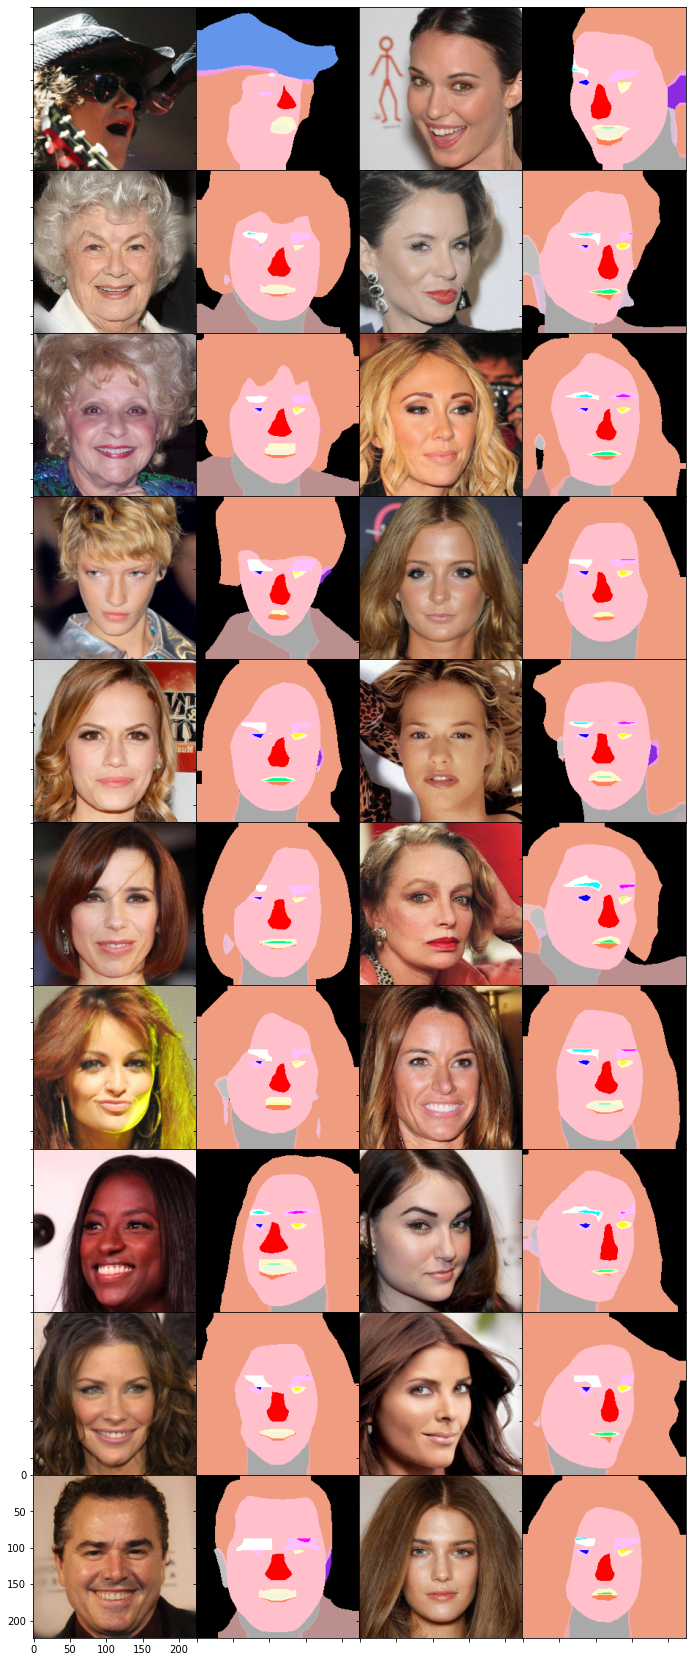

For Batch:  0
IOU Score(Mean):  tensor(0.8905, device='cuda:0')


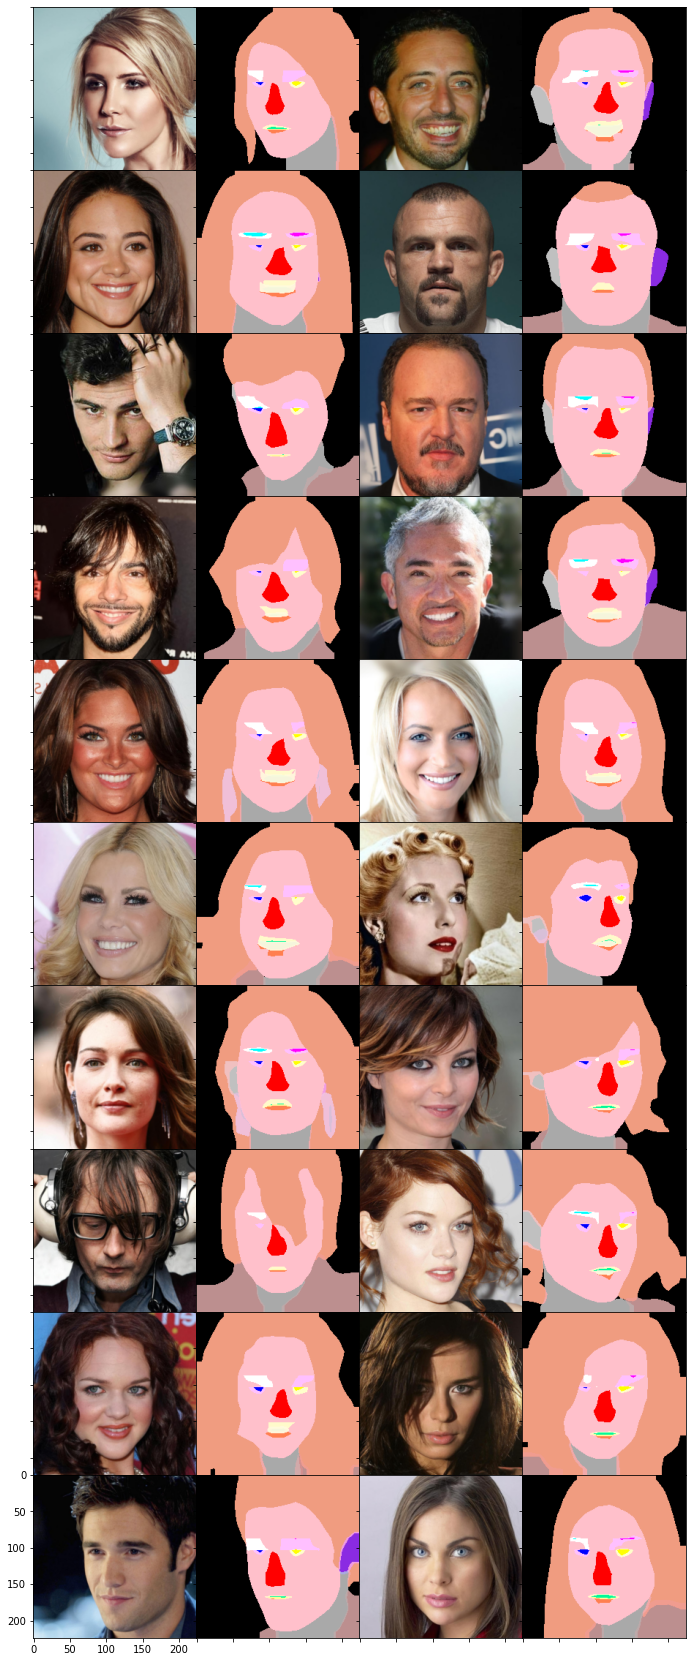

For Batch:  1
IOU Score(Mean):  tensor(0.8814, device='cuda:0')


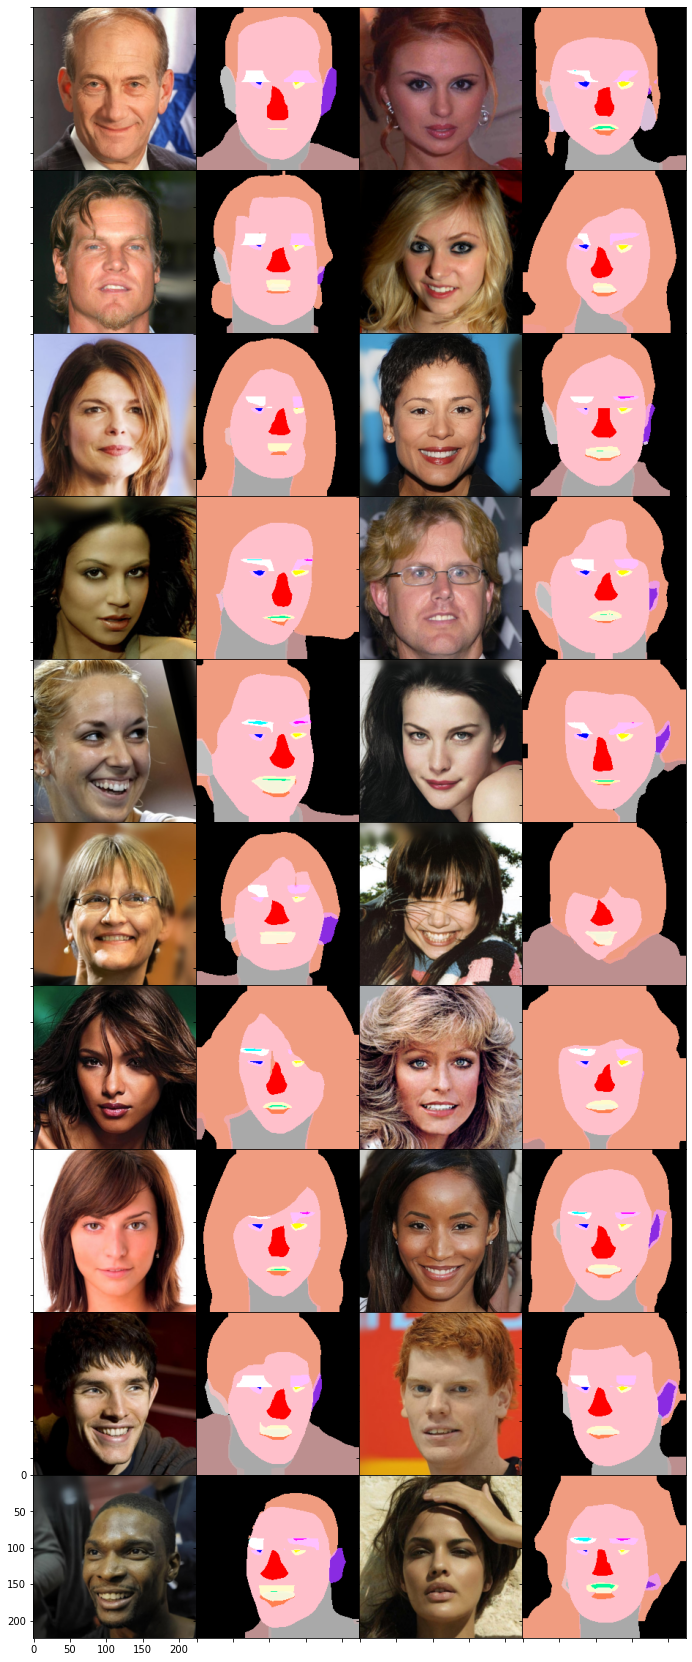

For Batch:  2
IOU Score(Mean):  tensor(0.8806, device='cuda:0')


In [22]:
x=0
y=0
for batch, (X, y) in enumerate(testloader):
  if batch == 3:
    break

  x = X
  y =y

  x = x.to(device)
  out = model(x)
  out = out['out'].to(device)
  yrv = unravel(y).to(device)
  outc = out_sf(out).to(device)
  outcv = unravel_out(outc)

  # Plot Image-Grid
  img_arr = color(outcv,x)

  # IOU
  torch.set_grad_enabled(False)
  intersection = torch.logical_and(yrv,outcv)
  union = torch.logical_or(yrv,outcv)
  iou_score = torch.sum(intersection) / torch.sum(union)
  iou_score
  print("For Batch: ", batch)
  print("IOU Score(Mean): ",iou_score)

***
***